# 01_Split_Videos.ipynb

Original code from Carolyn Parkinson & modified for personal use

Creates fslroi command to split whole run into individual videos

Input: 

* Run Ref File
    
    *  /Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles/239_run_ref.csv
    * Contains "sub_id, trial, video_number, self_other, neg_pos, scan_start, video_start, video_start_rts, run"
   
* Run File
    
Output: 
   
* Video run file

In [1]:
import os
import subprocess
import pandas as pd

from nilearn import input_data
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define a function to execute shell commands
def sh(c):
    '''
    run shell commands
    '''
    subprocess.call(c, shell = True)
    
import math

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

In [3]:
# get subject data

sub = "289"
run = 1




subject = "sub-" + sub

data_filepath = os.path.join("/Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/", subject)
run_ref_filepath = "/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles/" + sub + "_run_ref.csv"

run_ref = pd.DataFrame.from_csv(run_ref_filepath)



#video_start_time = [11, 148, 285, 421]
#video_start_tr = [round_up_to_even(x)/2 + 3 - start for x in video_start_time]
#video_start_tr


In [22]:
# Get data only for relevant epi run

run_ref = run_ref[run_ref.run == run]

run_ref['video_number'] = run_ref['video_number'].astype(int)

#Calculate trs
# add three to account for hemodynamic lag
run_ref['video_start_tr'] = \
    [round_up_to_even(x)/2 + 3 for x in run_ref['video_start_rts']]
#    [round_up_to_even(x)/2 + 3 for x in run_ref['video_start_rts']]


In [23]:
# Split each epi into four videos
for index, video in enumerate(run_ref['video_number'].tolist()): 

    run_filename = "sub-289_task-emp_run-01_bold.nii"
    bold_input_filename = os.path.join(data_filepath, run_filename)

    video_filename = ("video_{video}.nii.gz").format(video=str(video))
    bold_output_filename = os.path.join(data_filepath, video_filename)

    start = run_ref.iloc[index]['video_start_tr']
    duration = 60 #60 trs or 120 seconds

    sh_cmd = ("""fslroi \
          {bold_input_filename}\
          {bold_output_filename}\
          {start}\
          {duration}""").format(bold_input_filename=bold_input_filename, bold_output_filename=bold_output_filename, start=start, duration=duration)
    sh(sh_cmd)
    print(sh_cmd)

fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/sub-289_task-emp_run-01_bold.nii          /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/video_11.nii.gz          9.0          60
fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/sub-289_task-emp_run-01_bold.nii          /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/video_13.nii.gz          78.0          60
fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/sub-289_task-emp_run-01_bold.nii          /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/video_3.nii.gz          146.0          60
fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/sub-289_task-emp_run-01_bold.nii          /Users/mdclark/Desktop/ISCAnalysis/data/fmri/ts/nifti/sub-289/video_6.nii.gz          214.0          60


[9.0, 78.0, 146.0, 214.0]
(80, 80, 46, 273)
(80, 80, 46, 59)


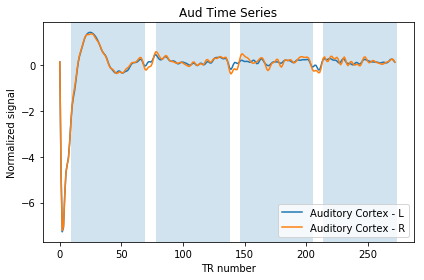

In [25]:
#Coded to check that TR onset and offset timing are correct


from nilearn import image
from nilearn import plotting

video_start = run_ref['video_start_tr'].tolist()
print(video_start)


#Load original and cut data
bold_input = image.smooth_img(bold_input_filename, fwhm=3)
bold_output= image.smooth_img(bold_output_filename, fwhm=3)

print(bold_input.shape)
print(bold_output.shape)

#Guess auditiory cortex seed
aud_coords = [(46,1,20),(-60,3,18)]
labels = ['Auditory Cortex - L', 'Auditory Cortex - R']

#Make mask of auditory cortex
masker = input_data.NiftiSpheresMasker(
    aud_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=1)


time_series = masker.fit_transform(bold_input)

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)
    
    
plt.axvspan(video_start[0],video_start[0]+60, alpha =.2)
plt.axvspan(video_start[1],video_start[1]+60, alpha =.2)
plt.axvspan(video_start[2],video_start[2]+60, alpha =.2)
plt.axvspan(video_start[3],video_start[3]+60, alpha =.2)

plt.title('Aud Time Series')
plt.xlabel('TR number')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()